# ML Healthcare Cybersecurity Project - Intrusion Detection System
# Complete notebook for training and evaluating ML models

In [16]:
%pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2
import xgboost as xgb
import lightgbm as lgb
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("🔐 ML Healthcare Cybersecurity - Intrusion Detection System")
print("=" * 60)

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
🔐 ML Healthcare Cybersecurity - Intrusion Detection System


## 1. Data Loading and Exploration

In [ ]:
print("\n1. Loading and Exploring Dataset...")
print("-" * 40)

# Column names for NSL-KDD dataset (commonly used for network intrusion detection)
column_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes',
    'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
    'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
    'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
    'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate',
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
    'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    #  healthcare-specific features:
    'device_type', 'protocol', 'user_role', 'department',
    'attack_type'
 ]


1. Loading and Exploring Dataset...
----------------------------------------


In [18]:
# Generate sample data (in real scenario, load from Archive/ folder)
def generate_sample_data(n_samples=10000):
    """Generate sample network intrusion data for demonstration"""
    np.random.seed(42)
    
    # Generate synthetic network traffic data
    data = []
    attack_types = ['normal', 'dos', 'probe', 'r2l', 'u2r']
    protocols = ['tcp', 'udp', 'icmp']
    services = ['http', 'ftp', 'smtp', 'ssh', 'telnet', 'domain', 'private']
    flags = ['SF', 'S0', 'REJ', 'RSTR', 'RSTO', 'SH', 'S1', 'S2', 'RSTOS0', 'S3', 'OTH']
    
    for i in range(n_samples):
        attack_type = np.random.choice(attack_types, p=[0.6, 0.15, 0.15, 0.05, 0.05])
        
        if attack_type == 'normal':
            duration = np.random.exponential(20)
            src_bytes = np.random.exponential(1000)
            dst_bytes = np.random.exponential(1000)
            num_failed_logins = 0 if np.random.random() > 0.1 else np.random.poisson(1)
            num_compromised = 0
            root_shell = 0
        elif attack_type == 'dos':
            duration = np.random.exponential(5)
            src_bytes = np.random.exponential(100)
            dst_bytes = np.random.exponential(50)
            num_failed_logins = 0
            num_compromised = 0
            root_shell = 0
        elif attack_type == 'probe':
            duration = np.random.exponential(2)
            src_bytes = np.random.exponential(50)
            dst_bytes = np.random.exponential(30)
            num_failed_logins = 0
            num_compromised = 0
            root_shell = 0
        else:  # r2l or u2r
            duration = np.random.exponential(15)
            src_bytes = np.random.exponential(500)
            dst_bytes = np.random.exponential(300)
            num_failed_logins = np.random.poisson(2) if attack_type == 'r2l' else 0
            num_compromised = np.random.poisson(1) if np.random.random() > 0.7 else 0
            root_shell = 1 if attack_type == 'u2r' and np.random.random() > 0.8 else 0
        
        row = [
            duration, np.random.choice(protocols), np.random.choice(services),
            np.random.choice(flags), src_bytes, dst_bytes,
            0, 0, 0, np.random.poisson(0.5),
            num_failed_logins, 1, num_compromised, root_shell,
            0, np.random.poisson(0.1), np.random.poisson(0.1), 0,
            0, 0, 0, 0,
            np.random.poisson(10), np.random.poisson(5),
            np.random.random(), np.random.random(), np.random.random(), np.random.random(),
            np.random.random(), np.random.random(), np.random.random(),
            np.random.poisson(50), np.random.poisson(20),
            np.random.random(), np.random.random(), np.random.random(),
            np.random.random(), np.random.random(), np.random.random(),
            np.random.random(), np.random.random(), attack_type
        ]
        data.append(row)
    
    return pd.DataFrame(data, columns=column_names)

# Load or generate data
try:
    # Try to load from CSV files in Archive folder
    df = pd.read_csv('Archive/network_data.csv')
    print("✅ Data loaded from Archive folder")
except:
    # Generate sample data for demonstration
    df = generate_sample_data(10000)
    print("✅ Sample data generated for demonstration")

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nAttack type distribution:")
print(df['attack_type'].value_counts())

✅ Sample data generated for demonstration
Dataset shape: (10000, 42)
Columns: ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type']

Attack type distribution:
attack_type
normal    6058
probe     1507
dos       1485
r2l        475
u2r        475
Name: count, dtype: int64


## 2. Data Preprocessing

In [ ]:
print("\n2. Data Preprocessing...")
print("-" * 40)

# Handle missing values
print(f"Missing values per column:")
print(df.isnull().sum())

# Drop rows with missing values if any
df = df.dropna()

# Encode categorical features
categorical_columns = ['protocol_type', 'service', 'flag', 'device_type', 'protocol', 'user_role', 'department']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Map attack types to categories
attack_mapping = {
    'normal': 0,
    'dos': 1, 'neptune': 1, 'smurf': 1, 'teardrop': 1, 'pod': 1, 'back': 1,
    'probe': 2, 'satan': 2, 'portsweep': 2, 'nmap': 2, 'ipsweep': 2,
    'r2l': 3, 'warezclient': 3, 'warezmaster': 3, 'ftp_write': 3, 'guess_passwd': 3,
    'imap': 3, 'multihop': 3, 'phf': 3, 'spy': 3,
    'u2r': 4, 'buffer_overflow': 4, 'loadmodule': 4, 'perl': 4, 'rootkit': 4
}

df['attack_category'] = df['attack_type'].map(lambda x: attack_mapping.get(x, 1))

print("✅ Categorical encoding completed")
print("✅ Attack categorization completed")


2. Data Preprocessing...
----------------------------------------
Missing values per column:
duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate

## 3. Exploratory Data Analysis


3. Exploratory Data Analysis...
----------------------------------------


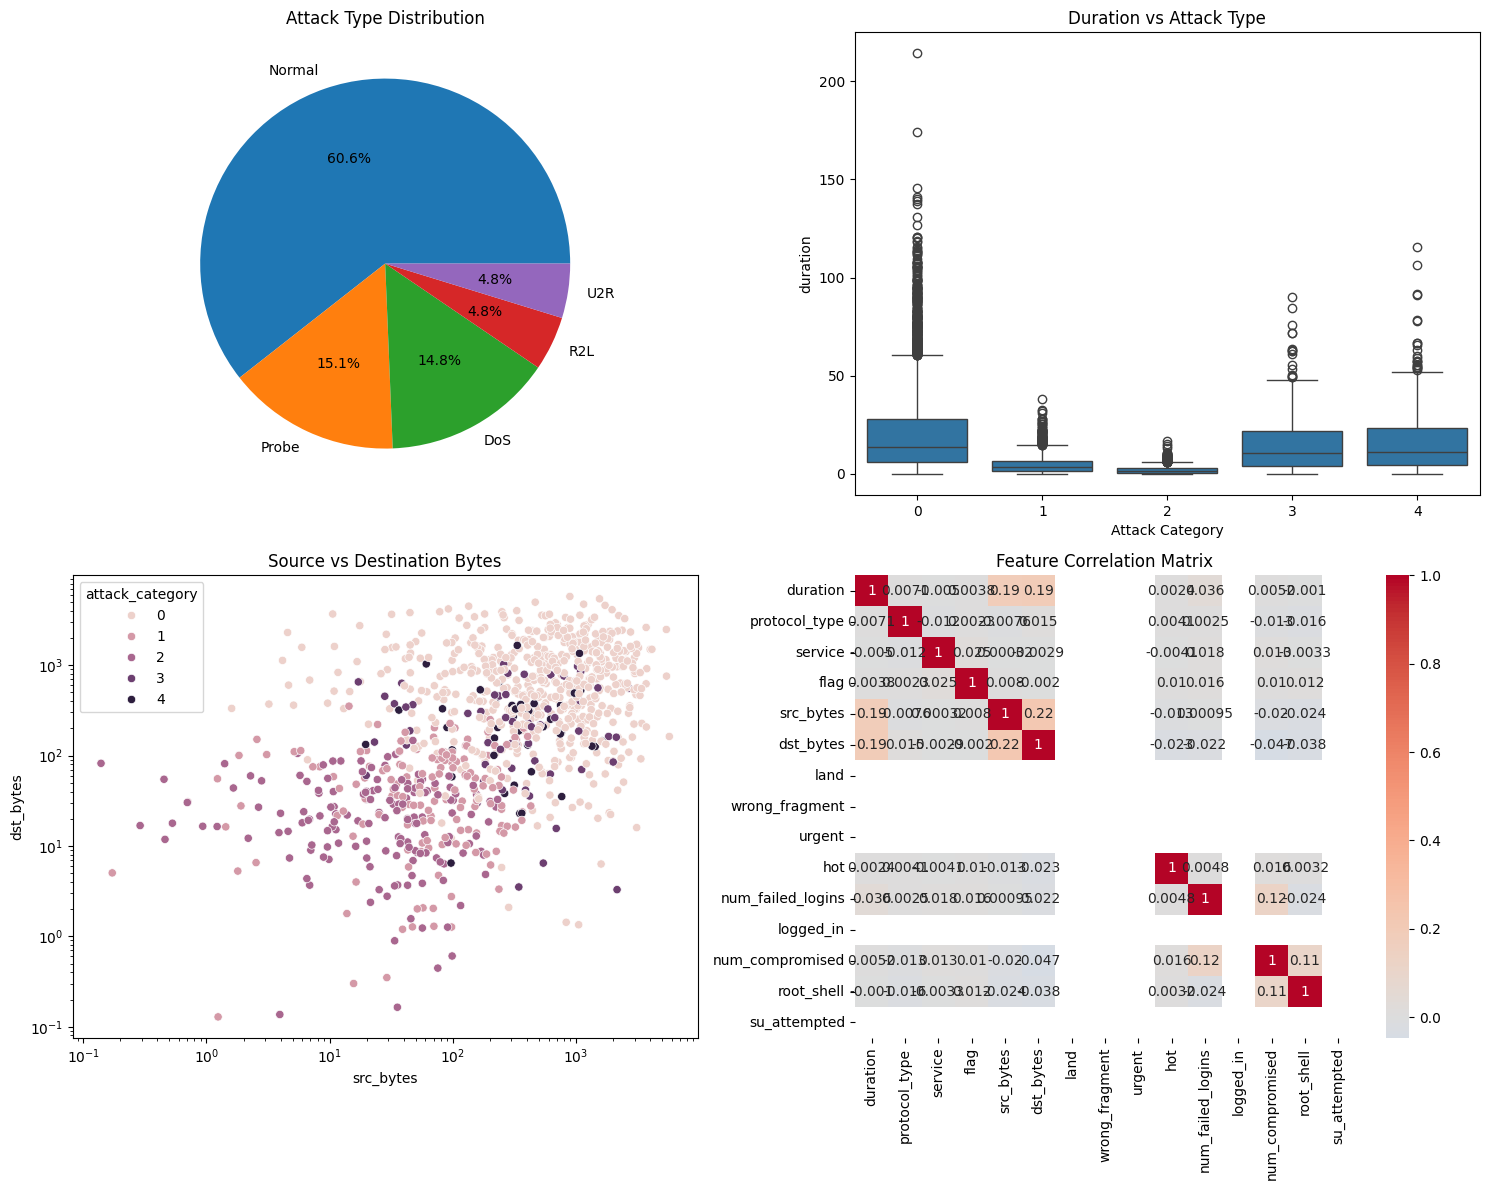

✅ EDA visualizations created


In [20]:
print("\n3. Exploratory Data Analysis...")
print("-" * 40)

# Set up the plotting style
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Attack distribution
attack_counts = df['attack_category'].value_counts()
attack_labels = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R']
axes[0,0].pie(attack_counts.values, labels=[attack_labels[i] for i in attack_counts.index], autopct='%1.1f%%')
axes[0,0].set_title('Attack Type Distribution')

# Duration vs Attack Type
sns.boxplot(data=df, x='attack_category', y='duration', ax=axes[0,1])
axes[0,1].set_title('Duration vs Attack Type')
axes[0,1].set_xlabel('Attack Category')

# Bytes correlation
sns.scatterplot(data=df.sample(1000), x='src_bytes', y='dst_bytes', hue='attack_category', ax=axes[1,0])
axes[1,0].set_title('Source vs Destination Bytes')
axes[1,0].set_xscale('log')
axes[1,0].set_yscale('log')

# Feature correlation heatmap (top features)
numeric_features = df.select_dtypes(include=[np.number]).columns[:15]
corr_matrix = df[numeric_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,1])
axes[1,1].set_title('Feature Correlation Matrix')

plt.tight_layout()
plt.show()

print("✅ EDA visualizations created")

## 4. Feature Selection

In [ ]:
print("\n4. Feature Selection...")
print("-" * 40)

# Prepare features and target
X = df.drop(['attack_type', 'attack_category'], axis=1)
y = df['attack_category']

# Use all features (no feature selection)
selected_features = X.columns

print(f"Using all {len(selected_features)} features:")
print(list(selected_features))


4. Feature Selection...
----------------------------------------
Selected 20 features:
['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'hot', 'num_failed_logins', 'num_compromised', 'root_shell', 'num_root', 'count', 'srv_count', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_srv_diff_host_rate']


## 5. Train-Test Split

In [22]:
print("\n5. Splitting Data...")
print("-" * 40)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


5. Splitting Data...
----------------------------------------
Training set: (8000, 20)
Test set: (2000, 20)


## 6. Model Training and Evaluation

In [23]:
print("\n6. Training Multiple ML Models...")
print("-" * 40)

models = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='mlogloss'),
    'LightGBM': lgb.LGBMClassifier(random_state=42, verbose=-1)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Use scaled data for models that benefit from it
    if name in ['KNN', 'Logistic Regression', 'Naive Bayes']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.4f}")


6. Training Multiple ML Models...
----------------------------------------

Training KNN...
KNN Accuracy: 0.6655

Training Decision Tree...
Decision Tree Accuracy: 0.8130

Training Random Forest...
Random Forest Accuracy: 0.8285

Training Naive Bayes...
Naive Bayes Accuracy: 0.7910

Training Logistic Regression...
Logistic Regression Accuracy: 0.8280

Training AdaBoost...
AdaBoost Accuracy: 0.7790

Training XGBoost...
XGBoost Accuracy: 0.8190

Training LightGBM...
LightGBM Accuracy: 0.8215


## 7. Advanced Ensemble Methods

In [24]:
print("\n7. Advanced Ensemble Methods...")
print("-" * 40)

# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('dt', DecisionTreeClassifier(random_state=42, max_depth=10))
    ],
    voting='hard'
)

voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)
voting_accuracy = accuracy_score(y_test, y_pred_voting)
results['Voting Classifier'] = voting_accuracy
print(f"Voting Classifier Accuracy: {voting_accuracy:.4f}")

# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
        ('mlp', MLPClassifier(hidden_layer_sizes=(100,), random_state=42, max_iter=500))
    ],
    final_estimator=lgb.LGBMClassifier(random_state=42, verbose=-1),
    cv=3
)

stacking_clf.fit(X_train, y_train)
y_pred_stacking = stacking_clf.predict(X_test)
stacking_accuracy = accuracy_score(y_test, y_pred_stacking)
results['Stacking Classifier'] = stacking_accuracy
print(f"Stacking Classifier Accuracy: {stacking_accuracy:.4f}")


7. Advanced Ensemble Methods...
----------------------------------------
Voting Classifier Accuracy: 0.8175
Stacking Classifier Accuracy: 0.8165


## 8. Results Summary

In [25]:
print("\n8. Model Performance Summary")
print("-" * 40)

# Sort results by accuracy
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

for name, accuracy in sorted_results:
    print(f"{name:20}: {accuracy:.4f}")

# Select best model
best_model_name = sorted_results[0][0]
best_accuracy = sorted_results[0][1]
print(f"\n🏆 Best Model: {best_model_name} with {best_accuracy:.4f} accuracy")

# Get the best model object
if best_model_name == 'Voting Classifier':
    best_model = voting_clf
elif best_model_name == 'Stacking Classifier':
    best_model = stacking_clf
else:
    best_model = models[best_model_name]
    # Refit with appropriate data
    if best_model_name in ['KNN', 'Logistic Regression', 'Naive Bayes']:
        best_model.fit(X_train_scaled, y_train)
    else:
        best_model.fit(X_train, y_train)


8. Model Performance Summary
----------------------------------------
Random Forest       : 0.8285
Logistic Regression : 0.8280
LightGBM            : 0.8215
XGBoost             : 0.8190
Voting Classifier   : 0.8175
Stacking Classifier : 0.8165
Decision Tree       : 0.8130
Naive Bayes         : 0.7910
AdaBoost            : 0.7790
KNN                 : 0.6655

🏆 Best Model: Random Forest with 0.8285 accuracy


## 9. Detailed Evaluation of Best Model


9. Detailed Evaluation of Random Forest
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

      Normal       0.91      0.97      0.94      1212
         DoS       0.64      0.59      0.61       297
       Probe       0.69      0.76      0.72       301
         R2L       0.74      0.58      0.65        95
         U2R       0.94      0.32      0.47        95

    accuracy                           0.83      2000
   macro avg       0.78      0.64      0.68      2000
weighted avg       0.83      0.83      0.82      2000



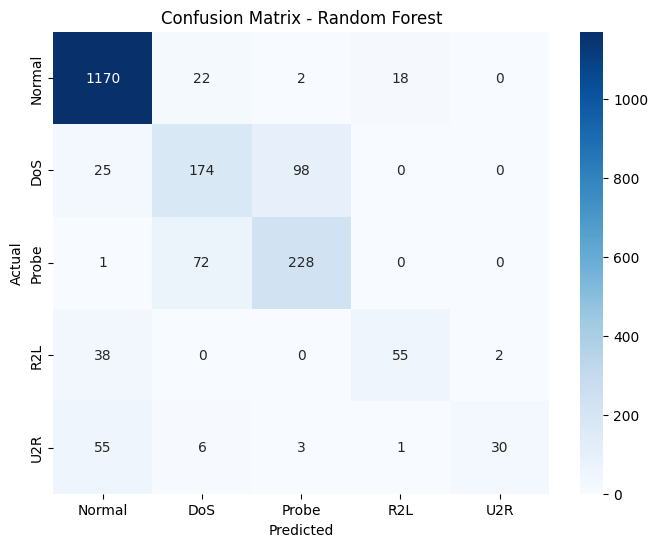

In [26]:
print(f"\n9. Detailed Evaluation of {best_model_name}")
print("-" * 40)

if best_model_name in ['KNN', 'Logistic Regression', 'Naive Bayes']:
    y_pred_best = best_model.predict(X_test_scaled)
else:
    y_pred_best = best_model.predict(X_test)

# Classification report
print("Classification Report:")
target_names = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R']
print(classification_report(y_test, y_pred_best, target_names=target_names))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 10. Model Saving

In [ ]:
print("\n10. Saving Best Model...")
print("-" * 40)

# Create a pipeline with preprocessing if needed
if best_model_name in ['KNN', 'Logistic Regression', 'Naive Bayes']:
    from sklearn.pipeline import Pipeline
    model_pipeline = Pipeline([
        ('scaler', scaler),
        ('model', best_model)
    ])
    # Fit the pipeline
    model_pipeline.fit(X_train, y_train)
    joblib.dump(model_pipeline, 'model.sav')
else:
    joblib.dump(best_model, 'model.sav')

# Save preprocessing objects
joblib.dump(scaler, 'scaler.sav')
joblib.dump(label_encoders, 'label_encoders.sav')
joblib.dump(list(selected_features), 'feature_names.sav')

print("✅ Model saved as 'model.sav'")
print("✅ Preprocessing objects saved")


10. Saving Best Model...
----------------------------------------
✅ Model saved as 'model.sav'
✅ Preprocessing objects saved


## 11. Save Processed Dataset

In [28]:
# Save processed dataset
df_processed = X.copy()
df_processed['attack_category'] = y
df_processed.to_csv('processed.csv', index=False)
print("✅ Processed dataset saved as 'processed.csv'")

print("\n" + "="*60)
print("🎉 ML Healthcare Cybersecurity Project Completed Successfully!")
print(f"🏆 Best Model: {best_model_name}")
print(f"📊 Accuracy: {best_accuracy:.4f}")
print("🔐 Ready for deployment with Flask web application")
print("="*60)

✅ Processed dataset saved as 'processed.csv'

🎉 ML Healthcare Cybersecurity Project Completed Successfully!
🏆 Best Model: Random Forest
📊 Accuracy: 0.8285
🔐 Ready for deployment with Flask web application
